# Single Image Super Resolution GAN

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import numpy as np

from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [2]:
train_dir = "/kaggle/input/mirflickr25k/mirflickr25k/mirflickr/"
output_dir = './'
!mkdir "hr_images"
!mkdir "lr_images"

def valid_image_file(file):
    """
    Check valid image filenames
    """
    return any(file.endswith(ext) for ext in 
               ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

def create_dataset(train_dir=train_dir, hr_size=128, lr_size=32):
    """
    Create low and high res datasets, according to hr_size and lr_size
    """
    for img in os.listdir(train_dir):
        if valid_image_file(img):
            img_array = cv2.imread(train_dir+img)
            img_array = cv2.resize(img_array, (hr_size,hr_size))
            lr_img_array = cv2.resize(img_array,(lr_size,lr_size))
            cv2.imwrite(output_dir+ "hr_images/" + img, img_array)
            cv2.imwrite(output_dir+ "lr_images/"+ img, lr_img_array)
    print("Created dataset.")

In [3]:
# Call with default params
create_dataset()

Created dataset.


# Generator

In [4]:
def ResidualBlock(inp):
    
    conv1 = Conv2D(64, (3,3), padding = "same")(inp)
    bn1 = BatchNormalization(momentum = 0.5)(conv1)
    prelu = PReLU(shared_axes = [1,2])(bn1)
    
    conv2 = Conv2D(64, (3,3), padding = "same")(prelu)
    bn2 = BatchNormalization(momentum = 0.5)(conv2)
    elemSum =  add([inp,bn2])
    
    return elemSum

def UpsampleBLock(inp):
    
    conv= Conv2D(256, (3,3), padding="same")(inp)
    pixelShuff = UpSampling2D( size = 2 )(conv)
    prelu = PReLU(shared_axes=[1,2])(pixelShuff)
    
    return prelu

In [5]:
### Generator Block

def Generator(gen_inp, num_res_block):
    conv1 = Conv2D(64, (9,9), padding="same")(gen_inp)
    prelu = PReLU(shared_axes=[1,2])(conv1)

    layers = prelu

    for i in range(num_res_block):
        layers =  ResidualBlock(layers)

    conv2 = Conv2D(64, (3,3), padding="same")(layers)
    bn = BatchNormalization(momentum=0.5)(conv2)
    elemSum = add([bn,prelu])

    upSample1 = UpsampleBLock(elemSum)
    upSample2 = UpsampleBLock(upSample1)

    out = Conv2D(3, (9,9), padding="same")(upSample2)

    return Model(inputs=gen_inp, outputs=out)

# Discriminator

In [6]:
def DiscriminatorBlock(inp, filters, strides=1, bn=True):
    
    layer = Conv2D(filters, (3,3), strides = strides, padding="same")(inp)

    if bn:
        layer = BatchNormalization( momentum=0.8 )(layer)
    
    leakyrelu = LeakyReLU( alpha=0.2 )(layer)
    
    return leakyrelu


In [7]:
def Discriminator(disc_inp):

    filter_ker = 64
    
    d1 = DiscriminatorBlock(disc_inp, filter_ker , bn=False)
    d2 = DiscriminatorBlock(d1, filter_ker , strides=2)
    d3 = DiscriminatorBlock(d2,filter_ker*2)
    d4 = DiscriminatorBlock(d3, filter_ker*2, strides=2)
    d5 = DiscriminatorBlock(d4, filter_ker*4)
    d6 = DiscriminatorBlock(d5, filter_ker*4, strides=2)
    d7 = DiscriminatorBlock(d6, filter_ker*8)
    d8 = DiscriminatorBlock(d7, filter_ker*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(filter_ker*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(inputs=disc_inp, outputs=validity)

# VGG Loss (Content Loss)

In [8]:
### Import VGG-19
from keras.applications.vgg19 import VGG19

### Pretained VGG-19 for feature extraction
def Vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

# Combined Model

In [9]:
def CombinedModel(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [10]:
### Loading 5k images for training

n=5000
lr_list = os.listdir("./lr_images")[:n]
hr_list = os.listdir("./hr_images")[:n]

lr_images = []
hr_images = []
for lr_img,hr_img in zip(lr_list, hr_list):
    img_lr = cv2.imread("./lr_images/" + lr_img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    img_hr = cv2.imread("./hr_images/" + hr_img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


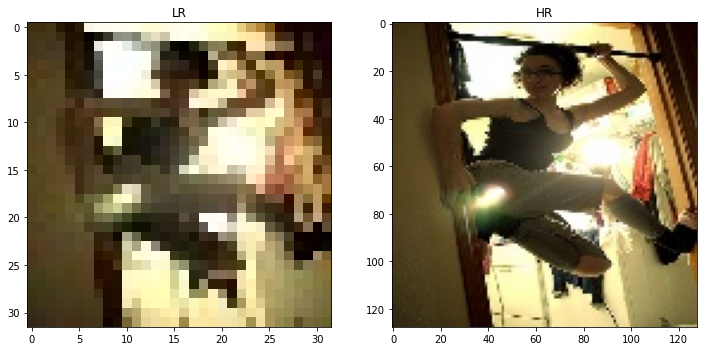

In [11]:
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.title('LR')
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.title('HR')
plt.show()

In [12]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [13]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [14]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
print(hr_shape, lr_shape)

(128, 128, 3) (32, 32, 3)


In [15]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [16]:
generator = Generator(lr_ip, num_res_block = 16)
discriminator = Discriminator(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

vgg = Vgg(hr_shape)
vgg.trainable = False

2022-10-02 16:45:37.799726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 16:45:37.890008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 16:45:37.890745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-02 16:45:37.892382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step


In [17]:
gan_model = CombinedModel(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=['binary_crossentropy',"mse"], loss_weights=[1e-3,1], optimizer="adam")
# Note, the losses are applied to outputs in order

In [18]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [19]:
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")


  0%|          | 0/3350 [00:00<?, ?it/s]2022-10-02 16:45:43.566110: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-02 16:45:44.614689: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 3350/3350 [07:20<00:00,  7.61it/s]


epoch: 1 g_loss: 75.18057716796648 d_loss: [1.14066818 0.83761194]


100%|██████████| 3350/3350 [07:03<00:00,  7.91it/s]


epoch: 2 g_loss: 55.7987582484288 d_loss: [0.22080617 0.94268657]


100%|██████████| 3350/3350 [07:02<00:00,  7.94it/s]


epoch: 3 g_loss: 54.170685028674 d_loss: [0.06811529 0.9861194 ]


100%|██████████| 3350/3350 [07:07<00:00,  7.85it/s]


epoch: 4 g_loss: 51.49078703595631 d_loss: [0.05823877 0.98865672]


100%|██████████| 3350/3350 [07:03<00:00,  7.90it/s]

epoch: 5 g_loss: 45.18692460173991 d_loss: [0.04130123 0.99641791]


In [22]:
generator.save('./generator.h5')
discriminator.save('./discriminator.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-10-02 17:28:53.192846: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.
2022-10-02 17:28:53.616074: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.
2022-10-02 17:28:53.909091: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.


# Test

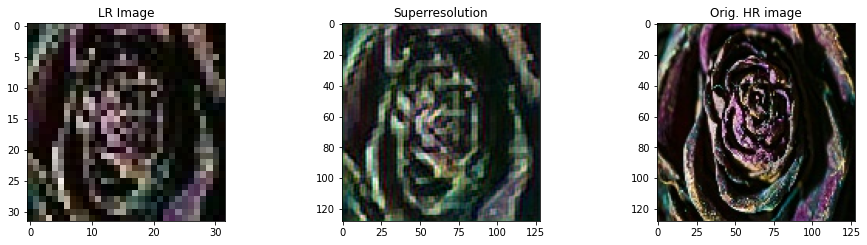

In [26]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('./generator.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

['hr_images', '.virtual_documents', '__notebook_source__.ipynb', 'lr_images']